# stitch_satchunks_by_date

- Take all satellite chunks for each day and stitch them together
- Remove those that cover less than one half of the glacier
- Crop remaining miages to the study area
- Move final files into a new folder to prepare for autoRIFT velocity mapping

In [16]:
import rasterio as rio
from rasterio.mask import mask
import cv2
import fiona
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import subprocess
import shutil
from scipy.interpolate import interp2d
import glob 
import geopandas as gpd
from shapely.geometry import mapping

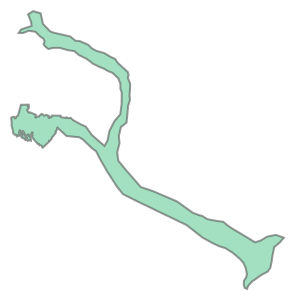

In [7]:
# path to glacier shapefile
glacier_shp = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/main_ice_outline.shp'
glacier_gdf = gpd.read_file(glacier_shp)
glacier = glacier_gdf.geometry.values
glacier[0]

In [9]:
# SET IMAGE PATH
basepath = '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/'

In [10]:
# grab all the unique dates
dates = []
for file in os.listdir(basepath+'stitched_by_sat/'): # path
    date = file.split('_')[1] # grab the date from the file name
    dates.append(date)
unique_dates = list(set(dates)) # save a list of the dates
unique_dates.sort() # sort the dates
print(unique_dates)

['20200302', '20200303', '20200304', '20200306', '20200312', '20200313', '20200315', '20200316', '20200318', '20200322', '20200326', '20200328', '20200329', '20200330']


TILES FOR 20200302
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200302_106b.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200302_105a.tif']


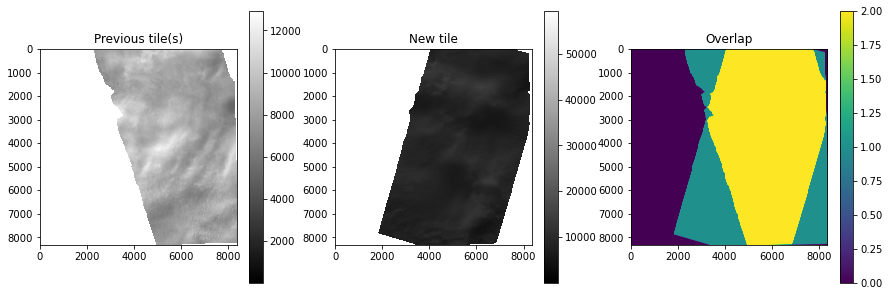

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 157.26744733751912
New mean diff: 0.0


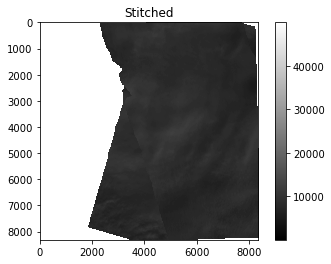

TILES FOR 20200303
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200303_106c.tif']


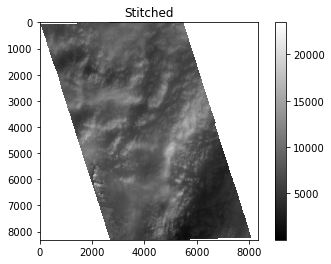

TILES FOR 20200304
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200304_1068.tif']


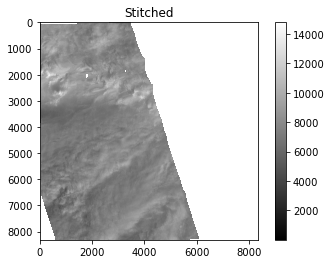

TILES FOR 20200306
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200306_106b.tif']


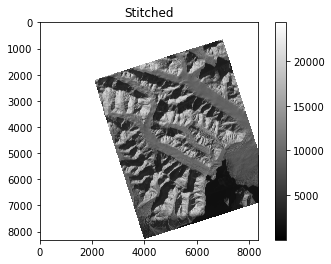

TILES FOR 20200312
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200312_1003.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200312_101f.tif']


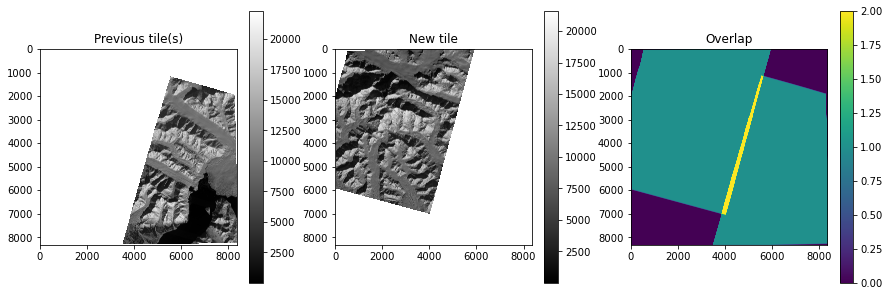

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 1154.7144898161732
New mean diff: 0.0


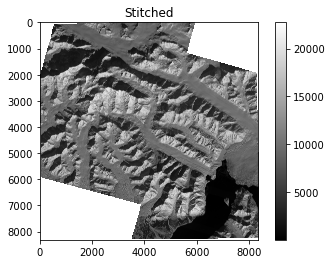

TILES FOR 20200313
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200313_105a.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200313_106e.tif']


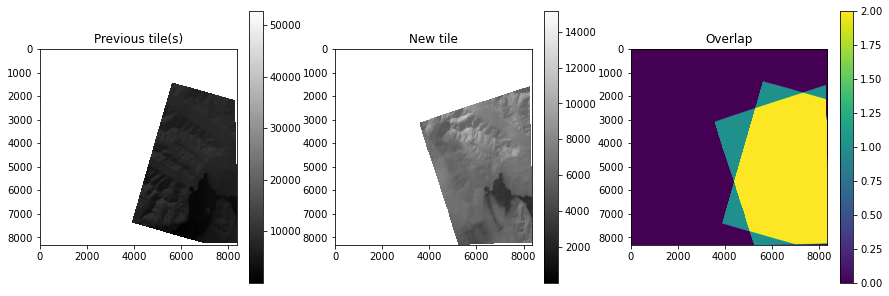

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 220.8168206914188
New mean diff: 0.0


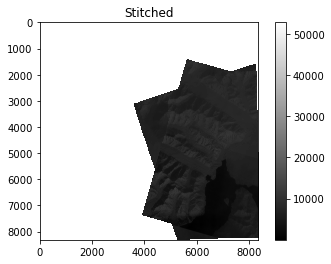

TILES FOR 20200315
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200315_1069.tif']


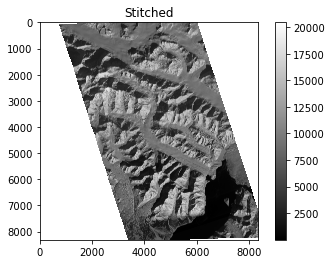

TILES FOR 20200316
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200316_1059.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200316_1063.tif']


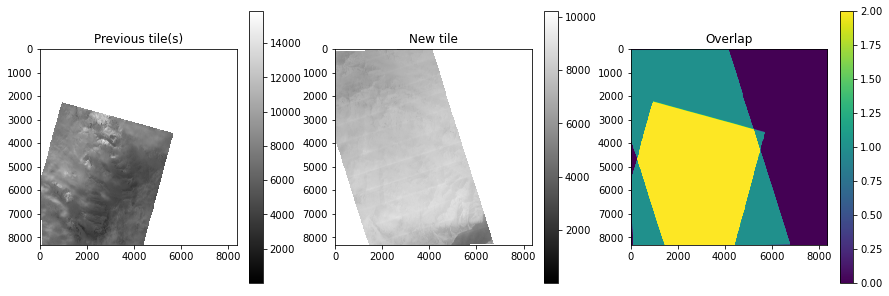

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -1556.6610031565233
New mean diff: 0.0


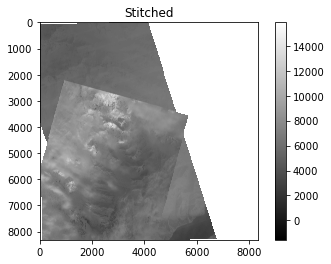

TILES FOR 20200318
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200318_106a.tif']


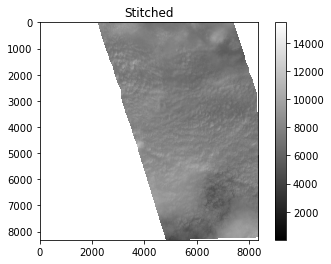

TILES FOR 20200322
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200322_1064.tif']


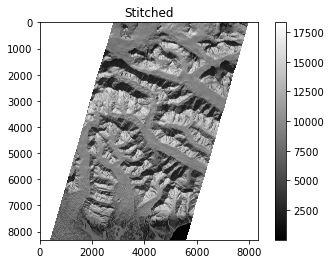

TILES FOR 20200326
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200326_103d.tif']


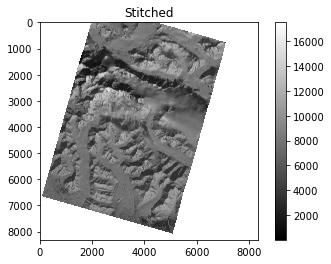

TILES FOR 20200328
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200328_105d.tif']


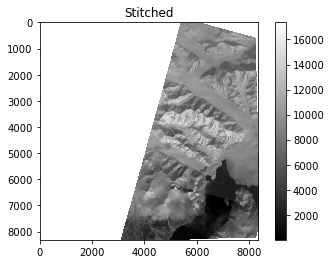

TILES FOR 20200329
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200329_1027.tif']


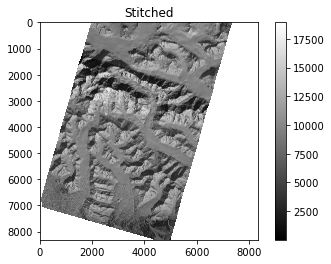

TILES FOR 20200330
['/Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_by_sat/PS_20200330_1065.tif']


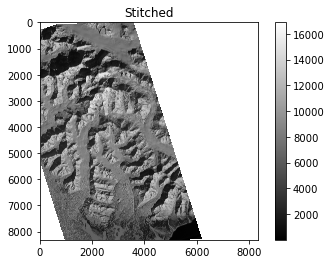

In [56]:
for date in unique_dates:  
    print('TILES FOR', date)
    tiles = glob.glob(basepath+'stitched_by_sat/PS_'+date+'*.tif') # grab all file paths for that date
    print(tiles)
    
    # initialize empty arrays
    reftile_reader = rio.open(tiles[0]); reftile = reftile_reader.read(1)
    overlap_total = np.zeros(reftile.shape);
    sr_stitched = np.zeros(reftile.shape) # start with empty stitched product
    t = 0 # tile count

    # Create glacier_ice_mask
    out_image, out_transform = mask(reftile_reader, [mapping(glacier[0])], crop=True)
    crop_array = out_image[0,:,:]
    crop_array[np.isnan(crop_array)] = 1; crop_array[crop_array > 0] = 1; # set to binary glacier area
    glacier_ice_mask = crop_array
    # y direction:
    y_add = 0 # default don't add
    half_diffy = (reftile.shape[0] - glacier_ice_mask.shape[0])/2
    if half_diffy < np.ceil(half_diffy):
        half_diffy = np.floor(half_diffy)
        y_add = 1
    half_diffy = int(half_diffy)

    # x-direciton
    x_add = 0 # default don't add
    half_diffx = (reftile.shape[1] - glacier_ice_mask.shape[1])/2
    if half_diffx < np.ceil(half_diffx):
        half_diffx = np.floor(half_diffx)
        x_add = 1
    half_diffx = int(half_diffx)

    # add the half diffs to glacier_ice_mask
    [ylen,xlen] = glacier_ice_mask.shape
    # y direction
    test_mask = np.concatenate([np.zeros((half_diffy,xlen)), glacier_ice_mask, np.zeros((half_diffy+y_add,xlen))],axis=0)
    [ylen,xlen] = test_mask.shape
    test_mask = np.concatenate([np.zeros((ylen, half_diffx)), test_mask, np.zeros((ylen, half_diffx+x_add))],axis=1)
    test_mask.shape

    glacier_ice_mask = test_mask
    
    for tile in tiles:
        reader = rio.open(tile); sr = reader.read(1) # load the tile
        sr[sr == 0] = np.NaN # remove black background, replace with Nans
        sr_data = sr.copy() # make a copy of the data before making the data binary
        sr[sr>0.0] = 1 ; sr[np.isnan(sr)] = 0 # make tile binary
        
        tilesize = np.count_nonzero(sr) # grab the current tile size (pixels)
        overlap_total = overlap_total+sr # add new overlap to overlap total
        
        if t == 0: # for the first tile
            sr_stitched = sr_stitched+sr_data # add the data to sr_stitched
            overlap_area = 0 # no overlap area for the first tile
        
        else: # for all subsequent tiles, do iterative normalization based on overlapping area, if any
            overlap_area = np.count_nonzero(overlap_total[overlap_total >= 2]) # update total overlap area
            
            # Plot the tile comparison and overlap
            fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
            im1 = ax1.imshow(sr_stitched,cmap='gray'); ax1.set_title('Previous tile(s)'); fig.colorbar(im1,ax=ax1)
            im2 = ax2.imshow(sr_data,cmap='gray'); ax2.set_title('New tile'); fig.colorbar(im2, ax=ax2)
            im3 = ax3.imshow(overlap_total,vmin=0,vmax=2); ax3.set_title('Overlap'); fig.colorbar(im3,ax=ax3)
            plt.show()
            
            # if the total overlap area has increased (i.e., new overlap)
            if overlap_area > prev_overlap: # increase in overlapping area indicates we have 2 overlapping tiles!!!
                overlap_band = ma.masked_not_equal(overlap_total, 2) # identify non-overlapping area (not 2)
                overlap_band_mask = ma.getmaskarray(overlap_band) # grab the mask for the overlapping area
                
                # identify which tile is larger
                if tilesize > prev_tilesize:
                    print('Current tile is larger.')
                    larger_tile = sr_data; smaller_tile = sr_stitched # assign the tiles
                elif tilesize < prev_tilesize:
                    print('Previous tile is larger.')
                    larger_tile = sr_stitched; smaller_tile = sr_data # assign the tiles
                else: # equal sizes
                    print('Tiles are the same size.')
                    larger_tile = sr_data; smaller_tile = sr_stitched # use current tile to coregister
                
                # grab mean pixel difference from overlapping area (ON GLACIER)
                overlap_values_l = ma.masked_where(overlap_band_mask, larger_tile)
                overlap_values_larger = ~overlap_values_l.mask*overlap_values_l.data
                overlap_values_s = ma.masked_where(overlap_band_mask, smaller_tile)
                overlap_values_smaller = ~overlap_values_s.mask*overlap_values_s.data
                diff = np.nanmedian(np.subtract(overlap_values_larger,overlap_values_smaller)) # median diff
                print('Mean difference in values from the larger tile in overlap area:', diff)
                
                # mean difference in overlapping area over glacier
                overlap_glacier_l = ma.masked_where(glacier_ice_mask, overlap_values_larger)
                overlap_glacier_larger = overlap_glacier_l.mask*overlap_glacier_l.data
                overlap_glacier_s = ma.masked_where(glacier_ice_mask, overlap_values_smaller)
                overlap_glacier_smaller = overlap_glacier_s.mask*overlap_glacier_s.data
                diff2 = np.nanmedian(np.subtract(overlap_glacier_larger,overlap_glacier_smaller))
                print('New mean diff:', diff2)
                
                if diff2 != 0: # if there is glacier overlap, only shift with glacier difference
                    
                    # normalize the smaller tile's values to the larger reference tile's overlap values
                    smaller_tile_coreg = smaller_tile + diff2 # add the mean difference to all values
                    smaller_tile_coreg = ma.masked_where(~overlap_band_mask, smaller_tile_coreg) 

                    # remove overlap area from smaller tile:
                    masked_smaller_tile_coreg = ~smaller_tile_coreg.mask*smaller_tile_coreg.data
                    
#                     # SHOW THE OVERLAPPING AREA:
#                     plt.imshow(overlap_glacier_smaller); plt.colorbar(); plt.show()
                    
                else: # If not, shift with overlapping difference
                    smaller_tile_coreg = smaller_tile + diff # add the mean difference to all values
                    smaller_tile_coreg = ma.masked_where(~overlap_band_mask, smaller_tile_coreg) 

                    # remove overlap area from smaller tile:
                    masked_smaller_tile_coreg = ~smaller_tile_coreg.mask*smaller_tile_coreg.data
                  
                # add them to the stitched produdct
                sr_stitched = np.nansum([masked_smaller_tile_coreg, larger_tile],0) 
                overlap_total[overlap_total > 0] = 1 # refresh overlap total
            else: # if no overlap, just add them without doing anything
                sr_stitched = np.nansum([sr_data, sr_stitched],0) # add them to the stitched product

        # Store tile info for the next round of comparison
        prev_overlap = overlap_area # amount of pixels overlapping
        prev_tilesize = np.count_nonzero(sr_stitched) # previous tile size (pixels w/ data)
        sr_prev = sr_data
        sr_stitched[sr_stitched == 0]=np.NaN # fill black pixels with NaNs
        t += 1 # increment tile count
        
    # Plot final stitched image
    fig = plt.figure(); im = plt.imshow(sr_stitched, cmap='gray'); plt.title('Stitched'); 
    fig.colorbar(im); plt.show()

    # Export stitched image
    outfilename = 'PS_'+date+'.tif'
    if not os.path.exists(basepath+"stitched_images/"):
        os.mkdir(basepath+"stitched_images/")
    with rio.open(basepath+"stitched_images/"+outfilename,'w',
                        driver='GTiff',
                        height=sr_stitched.shape[0], # new shape
                        width=sr_stitched.shape[1], # new shape
                        dtype=sr_stitched.dtype, # data type
                        count=1,
                        crs=reftile_reader.crs, # the EPSG from the original DEM
                        transform=reftile_reader.transform) as dst:
            dst.write(sr_stitched, 1)
    #break
    del overlap_total; del sr_stitched # clear variables
    

# Remove images that cover < 50% of the glacier area

In [62]:
# Read glacier shapefile
shp_path = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/main_ice_outline.shp'
with fiona.open(shp_path, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [67]:
stitchedpath = basepath+'stitched_images/' # path to the stitched images
boxpath = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/BoxTurner/BoxTurner_UTM_07.shp'

# multiply each image by glacier mask
for file in os.listdir(stitchedpath):
    if file.startswith('PS') and not file.endswith('clipped.tif'):
        print(file)
        
        # read image file and crop to glacier outline
        with rio.open(stitchedpath+file) as src:
            out_image, out_transform = mask(src, shapes, crop=True)

        # calculate number of non-empty pixels over the glacier
        total_pixels = np.count_nonzero(out_image[0])
        out_image[np.isnan(out_image)] = 0 # set all Nans to 0
        pixels_w_data = np.count_nonzero(out_image) # count non nans (number of pixels with data)
        
        # print data percent
        data_percent = int(pixels_w_data/total_pixels*100)
        print(data_percent, '%')
        
        # remove if it does exist:
        if file[:-4]+'_clipped.tif' in os.listdir(stitchedpath):
            os.remove(stitchedpath+file[:-4]+'_clipped.tif')
            
        # if data percent > 50, and clipped version doesn't already exist:
        if data_percent >= 50:
            # Crop file
            crop_cmd = 'gdalwarp -cutline '+boxpath+' -crop_to_cutline '
            crop_cmd += stitchedpath+file+' '+stitchedpath+file[:-4]+'_clipped.tif'
            print(crop_cmd); print()

            subprocess.run(crop_cmd,shell=True,check=True); print()
        else:
            print('Remove', file)
#             os.remove(stitchedpath+file) # currently keeps it

PS_20200302.tif
86 %
gdalwarp -cutline /Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/BoxTurner/BoxTurner_UTM_07.shp -crop_to_cutline /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_images/PS_20200302.tif /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_images/PS_20200302_clipped.tif

Creating output file that is 8358P x 8315L.
Processing /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_images/PS_20200302.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.

PS_20200303.tif
100 %
gdalwarp -cutline /Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/BoxTurner/BoxTurner_UTM_07.shp -crop_to_cutline /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_images/PS_20200303.tif /Volumes/SURGE_DISK/PS_downloads_SK/download/PSScene/standard_grid/stitched_images/PS_20200303_clipped.tif

Creating output file that is 8358P x 8315L.
Processing /Volumes/SURGE_DISK/PS_dow

# Move into new folder

In [68]:
out_folder = '/Volumes/SURGE_DISK/PS_downloads_SK/noncloudy_for_autorift/'
    
for searchfile in os.listdir(stitchedpath):
    if searchfile.endswith('clipped.tif'):
        shutil.copy(stitchedpath+searchfile, out_folder+searchfile)